In [1]:
pip install tensorflow

In [2]:
# ------------------------------
# Step 1: Load Libraries and Dataset
# ------------------------------
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split

# Load dataset
data = pd.read_csv('/content/ner_dataset.csv', encoding='unicode_escape')
data['Sentence #'] = data['Sentence #'].fillna(method='ffill')

# ------------------------------
# Step 2: Prepare Token and Tag Mappings
# ------------------------------
def get_dict_map(data, token_or_tag):
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    idx2tok = {idx: tok for idx, tok in enumerate(vocab)}
    tok2idx = {tok: idx for idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok

token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

# Map tokens and tags
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)

# Group by sentences
data_group = data.groupby(['Sentence #'], as_index=False)[['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx']].agg(lambda x: list(x))

# ------------------------------
# Step 3: Padding and Data Splitting
# ------------------------------
def get_pad_train_test_val(data_group, data):
    n_token = len(token2idx)
    n_tag = len(tag2idx)

    tokens = data_group['Word_idx'].tolist()
    tags = data_group['Tag_idx'].tolist()
    maxlen = max(len(s) for s in tokens)

    pad_tokens = pad_sequences(tokens, maxlen=maxlen, padding='post', value=n_token - 1)
    pad_tags = pad_sequences(tags, maxlen=maxlen, padding='post', value=tag2idx['O'])
    pad_tags = [to_categorical(i, num_classes=n_tag) for i in pad_tags]

    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_, tags_, test_size=0.25, random_state=2020)

    print(f"Train: {len(train_tokens)}, Val: {len(val_tokens)}, Test: {len(test_tokens)}")
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags, maxlen

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags, maxlen = get_pad_train_test_val(data_group, data)

# ------------------------------
# Step 4: Load GloVe Embeddings
# ------------------------------
def load_glove_embeddings(glove_file_path, embedding_dim):
    embeddings_index = {}
    with open(glove_file_path, encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Loaded {len(embeddings_index)} word vectors from GloVe.')
    return embeddings_index

def create_embedding_matrix(token2idx, embeddings_index, embedding_dim):
    vocab_size = len(token2idx) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in token2idx.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# Load and prepare GloVe
glove_path = '/content/glove.6B.100d.txt'  # Ensure this path is correct
embedding_dim = 100
glove_embeddings = load_glove_embeddings(glove_path, embedding_dim)
embedding_matrix = create_embedding_matrix(token2idx, glove_embeddings, embedding_dim)

# ------------------------------
# Step 5: Define BiLSTM-LSTM Model with GloVe
# ------------------------------
def get_bilstm_lstm_model_with_glove(embedding_matrix, input_length, n_tags, embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0],
                        output_dim=embedding_dim,
                        input_length=input_length,
                        weights=[embedding_matrix],
                        trainable=False))

    model.add(Bidirectional(LSTM(units=embedding_dim, return_sequences=True, dropout=0.2)))
    model.add(LSTM(units=embedding_dim, return_sequences=True, dropout=0.5))
    model.add(TimeDistributed(Dense(n_tags, activation="softmax")))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

n_tags = len(tag2idx)
model = get_bilstm_lstm_model_with_glove(embedding_matrix, maxlen, n_tags, embedding_dim)

# ------------------------------
# Step 6: Train the Model
# ------------------------------
def train_model(X, y, model):
    loss = []
    for i in range(25):
        hist = model.fit(X, y, batch_size=128, epochs=1, verbose=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss

results = pd.DataFrame()
results['with_glove'] = train_model(train_tokens, np.array(train_tags), model)

# ------------------------------
# Step 7: Optional Visualization with spaCy (if desired)
# ------------------------------
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

<ipython-input-2-5be7ed0af8d8>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Sentence #'] = data['Sentence #'].fillna(method='ffill')


Train: 32372, Val: 10791, Test: 4796
Loaded 400000 word vectors from GloVe.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     3,517,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,517,900 (13.42 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,517,900 (13.42 MB)

203/203 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.9375 - loss: 0.5497 - val_accuracy: 0.9701 - val_loss: 0.0969
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9718 - loss: 0.0924 - val_accuracy: 0.9754 - val_loss: 0.0765
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9754 - loss: 0.0760 - val_accuracy: 0.9770 - val_loss: 0.0689
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9770 - loss: 0.0694 - val_accuracy: 0.9785 - val_loss: 0.0642
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9785 - loss: 0.0653 - val_accuracy: 0.9798 - val_loss: 0.0608
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9800 - loss: 0.0609 - val_accuracy: 0.9812 - val_loss: 0.0574
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9811 - loss: 0.0579 - val_accuracy: 0.9818 - val_loss: 0.0560
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9816 - loss: 0.0570 - val_accuracy: 0.9822 - val_loss: 0.0540
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0

In [3]:
text = nlp('''On January 20, 2021, Joseph R. Biden Jr. was sworn in as the 46th President of the United States, taking over from Donald Trump. The inauguration ceremony took place in Washington, D.C., in front of the U.S. Capitol and was attended by dignitaries including Barack Obama, George W. Bush, and Bill Clinton.

During the event, Lady Gaga sang the national anthem, and Amanda Gorman delivered a powerful poem that went viral across social media platforms like Twitter and YouTube.

Meanwhile, in Silicon Valley, Sundar Pichai, the CEO of Google, announced a $1 billion investment in affordable housing in California. This followed Tim Cook's earlier commitment of $2.5 billion from Apple toward solving the housing crisis.

In Europe, Angela Merkel met with Emmanuel Macron at the Élysée Palace in Paris to discuss the European Union’s response to the ongoing energy crisis caused by reduced gas supplies from Russia. At the same time, NATO forces in Poland conducted joint military exercises with troops from Estonia and Lithuania.

Else
''')
displacy.render(text, style='ent', jupyter=True)

In [4]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [5]:
  history = model.fit(
    train_tokens, np.array(train_tags),
    batch_size=128,
    epochs=25,
    validation_data=(val_tokens, np.array(val_tags)),
    verbose=1
)

Epoch 1/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9854 - loss: 0.0442 - val_accuracy: 0.9849 - val_loss: 0.0456
Epoch 2/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9857 - loss: 0.0435 - val_accuracy: 0.9850 - val_loss: 0.0453
Epoch 3/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9859 - loss: 0.0427 - val_accuracy: 0.9850 - val_loss: 0.0453
Epoch 4/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.9858 - loss: 0.0427 - val_accuracy: 0.9852 - val_loss: 0.0448
Epoch 5/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.9860 - loss: 0.0423 - val_accuracy: 0.9851 - val_loss: 0.0450
Epoch 6/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9861 - loss: 0.0421 - val_accuracy: 0.9854 - val_loss: 0.0445
Epoch 7/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9861 - loss: 0.0419 - val_accuracy: 0.9853 - val_loss: 0.0446
Epoch 8/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.9864 - loss: 0.0413 - 

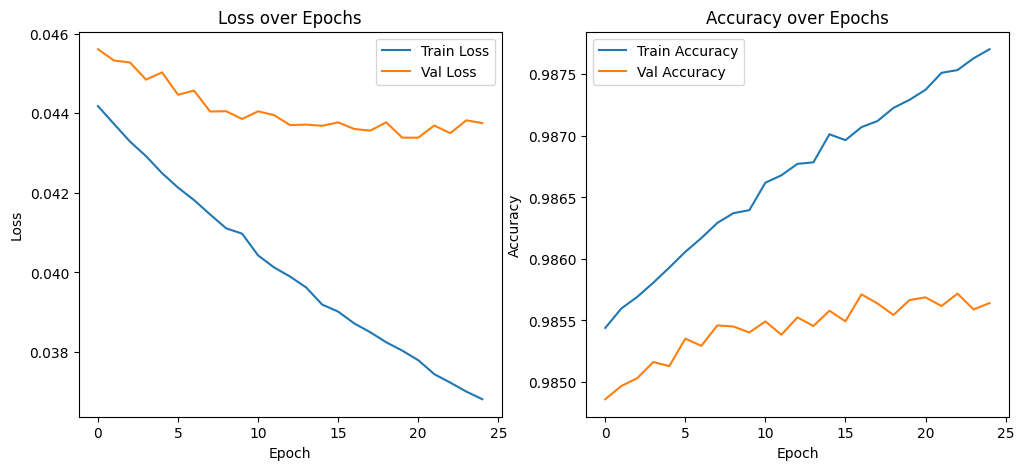

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()